# 4.2 Bond behavior governed by plasticity
 
Basic framework of
elasto-plastic models showing which conditions are used to find out how  
to describe the material behavior, once it crosses the elastic limit.
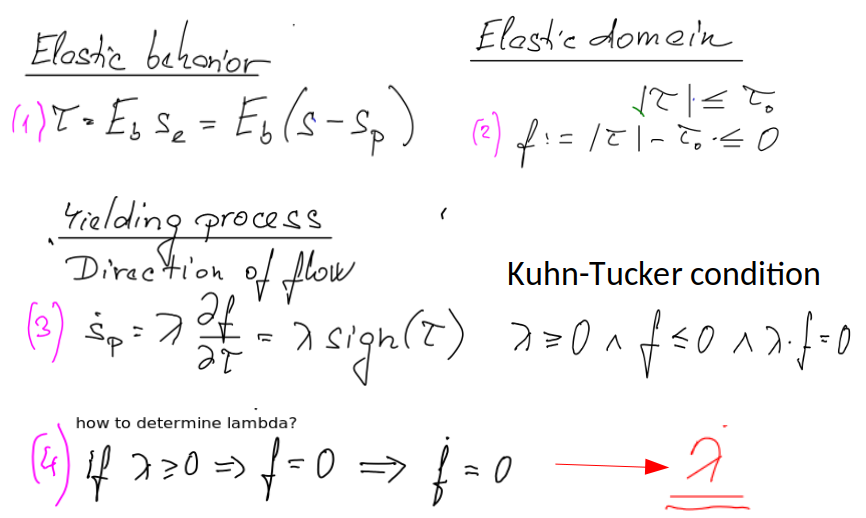

**Outline**
 * Perfect plasticity with constant level of yielding stress

 * Hardening variable that can expand the elastic range during the yielding process

 * Basic structure of a time-stepping algorithm for elastic-plastic material models

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Elastic,-ideally-plastic-behavior" data-toc-modified-id="Elastic,-ideally-plastic-behavior-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Elastic, ideally plastic behavior</a></span><ul class="toc-item"><li><span><a href="#Yield-condition" data-toc-modified-id="Yield-condition-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Yield condition</a></span></li><li><span><a href="#Elastic-behavior" data-toc-modified-id="Elastic-behavior-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Elastic behavior</a></span></li><li><span><a href="#Evolution-equation" data-toc-modified-id="Evolution-equation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Evolution equation</a></span></li><li><span><a href="#Consistency-condition" data-toc-modified-id="Consistency-condition-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Consistency condition</a></span></li></ul></li><li><span><a href="#Hardening---elastic-domain-changes-during-yielding" data-toc-modified-id="Hardening---elastic-domain-changes-during-yielding-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hardening - elastic domain changes during yielding</a></span><ul class="toc-item"><li><span><a href="#Yield-condition" data-toc-modified-id="Yield-condition-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Yield condition</a></span></li><li><span><a href="#Hardening-behavior" data-toc-modified-id="Hardening-behavior-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Hardening behavior</a></span></li><li><span><a href="#Evolution-equation" data-toc-modified-id="Evolution-equation-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Evolution equation</a></span></li><li><span><a href="#Consistency-condition" data-toc-modified-id="Consistency-condition-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Consistency condition</a></span></li></ul></li><li><span><a href="#Numerical-iterative-solution" data-toc-modified-id="Numerical-iterative-solution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Numerical iterative solution</a></span><ul class="toc-item"><li><span><a href="#Discrete-yield-condition" data-toc-modified-id="Discrete-yield-condition-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Discrete yield condition</a></span></li><li><span><a href="#State-update" data-toc-modified-id="State-update-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>State update</a></span></li><li><span><a href="#Predictor-operator" data-toc-modified-id="Predictor-operator-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Predictor operator</a></span></li><li><span><a href="#Time-stepping-algorithm" data-toc-modified-id="Time-stepping-algorithm-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Time stepping algorithm</a></span></li><li><span><a href="#Tasks-and-questions" data-toc-modified-id="Tasks-and-questions-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Tasks and questions</a></span></li></ul></li></ul></div>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
sp.init_printing()

## Elastic, ideally plastic behavior
Assuming a constant yielding stress $\tau_\mathrm{Y}$ and no hardening the possible paths along which the stress strain states can develop are depicted in Figure 1.
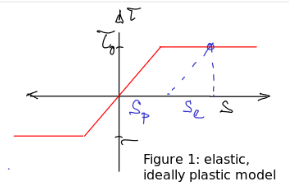

### Yield condition
Elastic domain is defined by the inequality equation
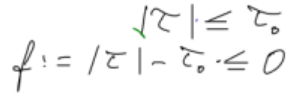
\begin{align}
f := | \tau| - \tau_Y \le 0
\label{eq:f_perfect_plasticity}
\end{align}

In [3]:
tau = sp.symbols(r'\tau')
tau_Y = sp.symbols(r'tau_Y', real=True, nonnegative=True)
f_tau_ = sp.sqrt( tau*tau ) - tau_Y
f_tau_ 

&nbsp;<font color='blue'>
**Naming conventions:**
 - Variables with trailing underscore (e.g. `f_tau_`) denote `sympy` expressions. 
 - Variables denoting `sympy` symbols (e.g. `tau` have no underscore at the end and have an the name which is close to the mathematical symbol
 - Mathematical symbols defined as string in `sp.symbols(r'\tau')` use `latex` syntax to introduce greek symbols, super and subindexes. This makes the pretty printing of expression possible.
 - In an implemented algorithm at the end of the notebook, the Python variables containing the numerical values of the material parameters $E_b$, $\tau_\mathrm{Y}$, etc. are denoted with a leading underscore `_E_b` and `_tau_Y` to avoid name collisions within the notebook
</font>

### Elastic behavior
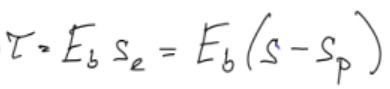
\begin{align}
\tau = E_\mathrm{b} s(s - s_\mathrm{pl})
\label{eq:elastic_behavior}
\end{align}

In [4]:
s, s_pl = sp.symbols('s, s_pl')
E_b = sp.symbols('E_b', positive=True)
tau_ =  E_b * (s - s_pl)
tau_

&nbsp;<font color="blue">
**Just an idea...**: We want to derive the relation between $\tau$ and $s$ in inelastic regime. What about to get rid of the unknown $s_\mathrm{pl}$ by substituting for the stress in $\eqref{eq:f_perfect_plasticity}$ the elastic constitutive law $\eqref{eq:elastic_behavior}$ and resolve the condition for $s_\mathrm{pl}$?
</font>

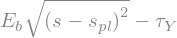

In [5]:
f_s = f_tau_.subs(tau, tau_)
f_s

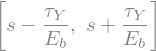

In [6]:
s_pl_f0 = sp.solve(f_s, s_pl)
s_pl_f0 

<font color="blue">
Once we substitute back the value $s_\mathrm{pl}$ into the constitutive equation $\tau = E_\mathrm{b}(s - s_\mathrm{pl})$ we just recover the fact that in inelastic regime, the stress must be equal to $\tau_\mathrm{Y}$. 
</font>

In [7]:
tau_.subs(s_pl, s_pl_f0[1])

<font color="blue">**... it's a dead end**</font>

### Evolution equation
Let us be more precise in defining the goal of the derivation: Inelastic behavior is path dependent. That means: <font color="brown"> **during yielding, the value of stress does not depend only on the value of slip but also on the history of loading in a material point.**</font> Thus, we cannot get an explicit relation between the stress and slip. 

We need further criteria that would help us
 * <font color="green">to find out **in which direction does the yielding process proceed** from a current state, and</font>
 * <font color="green">to account for **the loading history that a material point** experienced in the past.</font>

In other words, we want to establish the relation between stress and strain (or shear and slip) in a rate form,<br> i.e. $\dot{\tau}$ and $\dot{s}$. Which is a short form of $\displaystyle{\frac{\partial \tau}{\partial t}}$ and $\displaystyle{\frac{\partial s}{\partial t}}$, respectively.

Regarding Figure 2 - what is the direction of flow/yielding when $\tau = \tau_\mathrm{Y}$ and when $\tau = -\tau_\mathrm{Y}$?
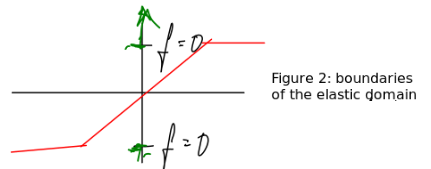

**Compass:** Let us postulate, that the amount of yielding can be mathematically controlled by a nonnegative variable $\lambda$. Yielding is assumed to proceed in a normal direction with respect to the yield surface $f$
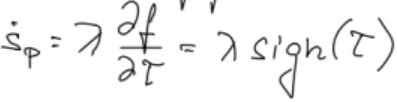
\begin{align}
\dot{s}^\mathrm{pl}
\label{eq:s_p_rage} = \lambda \frac{\partial f}{\partial \tau}
\end{align}

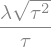

In [8]:
lambda_ = sp.symbols(r'\lambda', nonnegative=True)
dot_s_pl_ = lambda_ * f_tau_.diff(tau)
dot_s_pl_

But how far do we go along the direction given by the gradient $\partial f / \partial \tau$? The amount of yielding 
is now controlled by a new unknown variable $\lambda$? 

The idea that helps to sort this out and to mathematically distinguish the loading steps into elastic and inelastic ones is provided by the **Kuhn-Tucker condition**
\begin{align}
  \lambda f = 0, \; \lambda > 0,\; f \le 0
  \label{eq:kuhn_tucker}
\end{align}
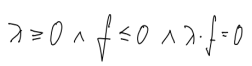
This construct acts as a switch between either growing $\lambda > 0$ (yielding) or negative $f < 0$ (elastic loading, or unloading) or both $\lambda = 0$ and $f=0$ (neutral loading). Still, it does not provide the additional condition to get $\lambda$ resolved in case of yielding ... 

### Consistency condition
If the material is yielding, then $f = 0$ and $\lambda \le 0$. Moreover, <font color="green">the value of $f$ must **remain zero** during the whole yielding process</font>. This means that the rate of the yield function, i.e. 
\begin{align}
\frac{ \mathrm{d} f}{\mathrm{d} t} = \dot{f} = 0
  \label{eq:consistency}
\end{align}
must remain zero as well. This is the sought condition that can be used to resolve for $\lambda$. 

To construct the rate of the yield condition let us recall that it depends on stress, which in turn depends on the control slip and on the plastic slip
\begin{align}
 f:= f( \tau (s, s^\mathrm{pl}) )
 \nonumber
\end{align}
Thus, to obtain $\dot{f}$ we  can apply the chain rule 
\begin{align}
\dot{f} &= \frac{\mathrm{d} f}{\mathrm{d} t} =
\frac{\partial f}{\partial \tau} \frac{\mathrm{d} \tau}{\mathrm{d} t} 
= \frac{\partial f}{\partial \tau} 
\left(
\frac{\partial \tau}{\partial s} \frac{\mathrm{d} s}{\mathrm{d} t} +
\frac{\partial \tau}{\partial s^\mathrm{pl}} \frac{\mathrm{d} s^\mathrm{pl}}{\mathrm{d} t}
\right)
= \frac{\partial f}{\partial \tau} E_\mathrm{b}\left( \dot{s} - \dot{s}^\mathrm{pl} \right)
  \label{eq:f_chain_derivatives}
\end{align}

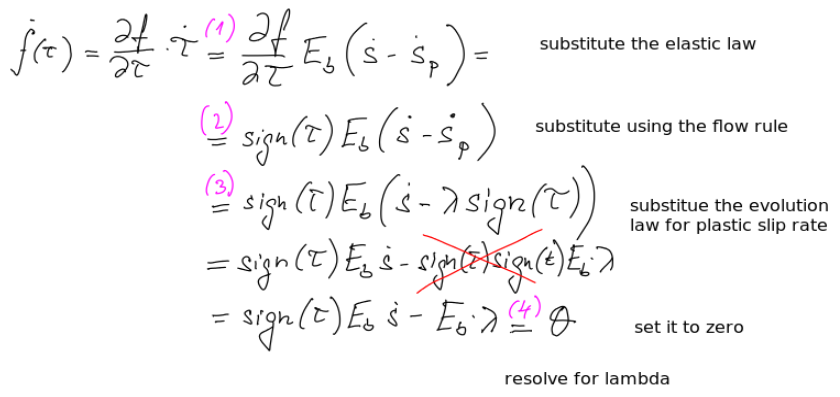

To realize this derivation in `sympy` let us transform the elastic relation from absolute values into the rate form
\begin{align}
\dot{\tau} = E_\mathrm{b}(\dot{s} - \dot{s}_\mathrm{pl})
\label{eq:elastic_rate}
\end{align}

In [9]:
dot_s, dot_s_pl = sp.symbols(r'\dot{s}, \dot{s}^\mathrm{pl}')
dot_tau_ = E_b * (dot_s - dot_s_pl)
dot_tau_ 

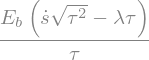

In [10]:
dot_f_ = f_tau_.diff(tau) * dot_tau_.subs(dot_s_pl, dot_s_pl_)
sp.simplify(dot_f_)

By setting this expression to zero and resolving for $\lambda$ we obtain 

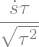

In [11]:
lambda_solved = sp.solve( dot_f_, lambda_)[0]
lambda_solved

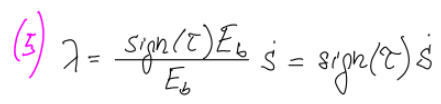

&nbsp;<font color="brown">
**The conclusion from the shown derivation is rather trivial - for perfectly plastic model without hardening or softening, the plastic slip grows along with the control slip with the same rate.**    
    </font>

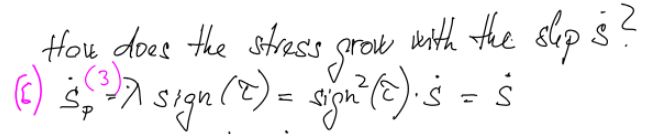

In [12]:
dot_s_pl_.subs(lambda_, lambda_solved)

&nbsp;<font color="brown">
**At the same time, upon yielding, the stress rate is zero, i.e. $\tau = \tau_\mathrm{Y}$.**
</font>

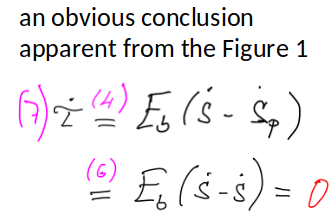

In [13]:
dot_tau_.subs(dot_s_pl, dot_s_pl_).subs(lambda_, lambda_solved)

## Hardening - elastic domain changes during yielding
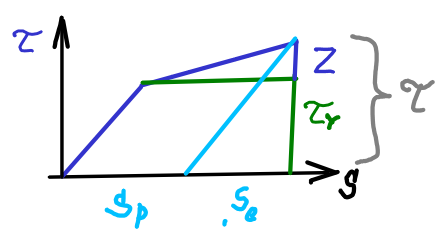
### Yield condition
\begin{align}
f = | \tau | - (\tau_Y + Z)
\label{eq:f_iso_hardening}
\end{align}

In [14]:
Z, X = sp.symbols('Z, X')
f_ = sp.sqrt((tau)*(tau)) - (tau_Y + Z)
f_

### Hardening behavior
The hardening force $Z$ is an additional stress measure. It must be accompanied with a corresponding kinematic variable, a hardening slip and a material parameter - hardening modulus $K$. Let us assume linear hardening relation
\begin{align}
 Z = K z \\
 X = \gamma \alpha
\label{eq:isotropic_hardening}
\end{align}
This relation will be needed to solve for the consistency condition in the rate form. Thus, in `sympy` we shall introduce directly $\dot{Z} = K \dot{z}$

In [15]:
K = sp.symbols(r'K', positive=True )
z = sp.symbols(r'z')
Z_ = K * z
dot_z = sp.symbols(r'\dot{z}')
dot_alpha = sp.symbols(r'\dot{\alpha}')
dot_Z_ = K * dot_z
dot_Z_, dot_tau_

### Evolution equation
As in case of ideal plasticity, the yielding process is controlled by the plastic multiplier $\lambda$ which must be non-negative. Following the same arguments as above, the  hardening slip $z$ is assumed to evolve in a normal direction with respect to the yield surface, i.e. 
\begin{align}
\frac{\mathrm{d} f }{ \mathrm{d} Z} = -1
\end{align}
To let the hardening slip $\dot{z}$ grow in a positive direction we introduce the evolution equation as
\begin{align}
\dot{z} = - \lambda  \frac{\mathrm{d} f }{ \mathrm{d} Z} = \lambda
\end{align}

&nbsp;
<font color='blue'>
**Side remark:** The choice of the sign in the evolution equation might seem somewhat arbitrary but it is not. If a hardening stress variable, $Z$ in this case, appears in the yield condition with a negative sign we need to take the minus sign in the evolution equation to let the hardening slip grow positive consistently with the growth of $\lambda$.
</font>

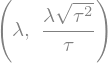

In [16]:
dot_s_pl_ = lambda_ * f_.diff(tau)
dot_z_ = - lambda_ * f_.diff(Z)
dot_z_, dot_s_pl_

### Consistency condition
The chain rule applied to express $\dot{f}$ needed for the consistency condition $\eqref{eq:f_chain_derivatives}$ renders an expression revealing the dependence on both $\dot{s}_\mathrm{pl}$ and $\dot{z}$
\begin{align}
 \dot{f} = 
     \frac{\partial f}{\partial \tau} \dot{\tau} 
+
    \frac{\partial f}{\partial Z} \dot{Z}
    \label{eq:f_isotropic}
\end{align}

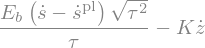

In [17]:
dot_f_ = f_.diff(tau) * dot_tau_ + f_.diff(Z) * dot_Z_
dot_f_

where the rates $\dot{s}_\mathrm{pl}$ and $\dot{z}$ can be substituted using the evolution equations 

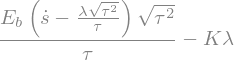

In [19]:
dot_f_lambda_ = dot_f_.subs(dot_s_pl, dot_s_pl_).subs(dot_z, dot_z_)
dot_f_lambda_

The only unkown in this expression is now the plastic multiplier $\lambda$. By setting this equation to zero we can finally express $\lambda$ as

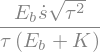

In [20]:
lambda_solved = sp.solve(dot_f_lambda_, lambda_)[0]
lambda_solved 

so that the rate of stress $\dot{\tau}$ can be finally obtained by substituting into the rate form of elastic constitutive equation and the evolution equation

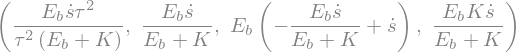

In [21]:
dot_s_pl_solved = dot_s_pl_.subs(lambda_, lambda_solved)
dot_tau_solved = dot_tau_.subs(dot_s_pl, dot_s_pl_solved)
dot_s_pl_solved, sp.simplify(dot_s_pl_solved), dot_tau_solved, sp.simplify(dot_tau_solved)

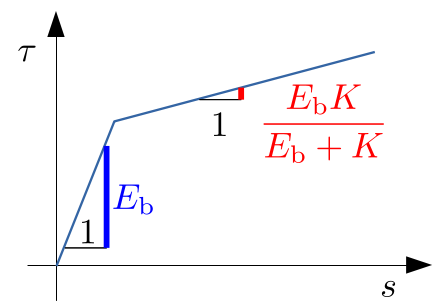
**Summary:** We have derived a relation between the rate of stress and and rate of slip. Thus, we can describe the change at the level of differentials. **However**, in order to simulate the behavior for a particular loading history we have to integrate these rate equations over the whole time line. 

Simply speaking: we have just rediscovered the well known wisdom -- It is impossible to say something about the future without accounting for the burden of the past. So the question is remains: 

<font color="green">**How to transform the differential continuous equations into an algorithm that can integrate over the time history?**</font>

## Numerical iterative solution
So far, we have expressed the change of the yield condition as a time derivative without considering the history that a material point went through. To move through an inelastic space of a material, let us now consider a discrete instance of time $t_n$ with the history represented by known values of $s_{n}$ and $s^{\mathrm{pl}}_{n}$ and $z_n$ for which the Kuhn-Tucker conditions $\eqref{eq:kuhn_tucker}$ are fulfilled.

Let us now prescribe an increment of total control slip $\Delta s$ to achieve the state at $t_{n+1}$ as
\begin{align}
s_{n+1} = s_n + \Delta s
\end{align}
Since the state variables $s^\mathrm{pl}_{n+1}, z_{n+1}$ are unknown, let us start by evaluating the yield function with the values known from the previous step
\begin{align}
f(s_{n+1}, s^{\mathrm{pl}}_n, z_n)
\end{align}
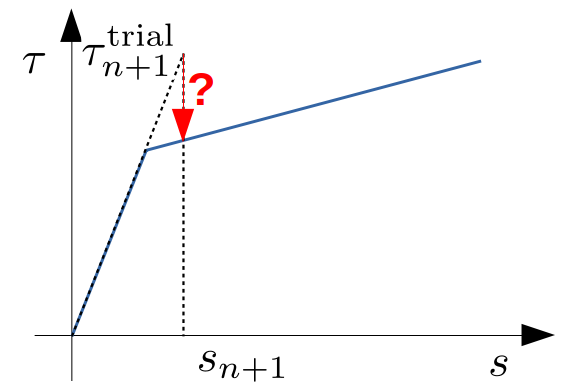

### Discrete yield condition
In a continuous case we consistency condition to explicitly glue the state onto the yield surface 
\begin{align}
 \dot{f}(\tau(s, s_\mathrm{pl}(\lambda), z(\lambda)) &= 0.
\end{align}
Thus, it was impossible to reach an inadmissible state beyond the yield locus. In discrete case, we relax this requirement. Indeed, by taking $f(s_{n+1}, s^{\mathrm{pl}}_n, z_n)$ as a first trial value we can obtain positive values.

&nbsp;<font color="green">
**We allow for "trial" states which lie beyond the admissible domain $f \le 0$ during iteration. This allows us to construct a "return mapping" algorithm that iteratively approaches an admissible state on the yield surface.**</font>

Given an inadmissible trial state $k$ with the yield condition $f_k > 0$, let us introduce a linearized approximation of its change along the plastic multiplier $\lambda$ around the state $k$. 
\begin{align}
 f_{k+1} &= f_{k} + \left. \frac{\partial f}{\partial \lambda} \right|_k \Delta \lambda
\end{align}
In this form, we can search for an admissible state $f_{n+1} = 0$ by iterating over $k$.
Note that in initial iteration $k = 0$ the state from previous step is reused, i.e. $f(s_{n+1}, s_n^\mathrm{pl}, z_n)$.

In the linearized form, we can transform the yield condition to a recurrent formula
\begin{align}
\left. \frac{\mathrm{d} f}{\mathrm{d} \lambda}\right|_k \Delta \lambda &= -f_k,
\hspace{1cm} f_k \rightarrow 0 \; \;\mathrm{for}\;\; k = 1\ldots\infty
\end{align}
This resembles the Newton method for iterative solution of a nonlinear equation. However, we need to consider the fact that the level of inadmissibility $f$ changes between iterations. 
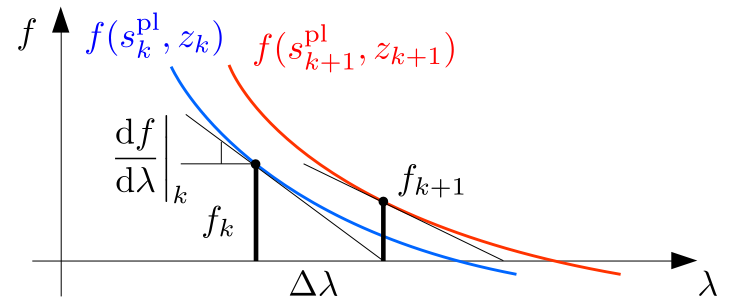
Note that the predictor is negative and $\Delta \lambda > 0$. In every step, the plastic multiplier is updated:
\begin{align}
\lambda_{k+1} &= \lambda_k + \Delta \lambda, \, \lambda_0 = 0 \nonumber \\ \nonumber
\end{align}

Two more questions must addressed to define a general numerical algorithm for plasticity:
<font color="brown">
 * **Update of state variables $s^\mathrm{pl}_{k+1}$ and $z_{k+1}$ in each iteration**
 * **Expression of the predictor $\mathrm{d} f / \mathrm{d} \lambda$ in terms of the state variables**
</font>

### State update
In every iteration step the state variables $s_\mathrm{pl}$ and $z$ must be updated using the discrete evolution equations, i.e. 

\begin{align}
s^\mathrm{pl}_{k+1} &= s^\mathrm{pl}_n + \lambda_{k+1} 
\left. \frac{\partial f}{\partial \tau} \right|_k \nonumber \\
z_{k+1} &= z_n - \lambda_{k+1} \left. \frac{\partial f}{\partial Z} \right|_k
\label{eq:discrete_evolution}
\end{align}

### Predictor operator
Recalling that $f(\tau(s,s^{\mathrm{pl}}(\lambda), z(\lambda)))$ the chain rule delivers the expression

\begin{align}
\left. \frac{\partial f}{\partial \lambda} \right|_k
&= 
\left.\frac{\partial f}{\partial \tau} \right|_k
\left.\frac{\partial \tau}{\partial s^{\mathrm{pl}}} \right|_k
\left.\frac{\partial s^{\mathrm{pl}}} {\partial \lambda} \right|_k
+
\left.\frac{\partial f}{\partial Z} \right|_k
\left.\frac{\partial Z}{\partial z} \right|_k
\left.\frac{\partial z}{\partial \lambda} \right|_k
\end{align}

after substituting the derivatives of the constitutive laws $\eqref{eq:elastic_behavior}$ and $\eqref{eq:isotropic_hardening}$ w.r.t. $s^{\mathrm{pl}}$ and $z$, respectively and, of the discrete evolution equations $\eqref{eq:discrete_evolution}$ w.r.t. $\lambda$ we obtain

\begin{align}
\left. \frac{\partial f}{\partial \lambda} \right|_k
&= -
\left. \frac{\partial f}{\partial \tau} \right|_k
E_\mathrm{b}
%\left. \frac{\partial \tau}{\partial s^{\mathrm{pl}}} \right|_k
\left. \frac{\partial f}{\partial \tau} \right|_k -
\left. \frac{\partial f}{\partial Z} \right|_k
K
%\left. \frac{\partial Z}{\partial z} \right|_k
\left. \frac{\partial f}{\partial Z} \right|_k
\end{align}
which can be finally expressed as
\begin{align}
\left. \frac{\partial f}{\partial \lambda} \right|_k
&= -
\left. \frac{\partial f}{\partial \tau} \right|_k^2 E_\mathrm{b} -
\left. \frac{\partial f}{\partial Z} \right|_k^2 K = -(E_\mathrm{b} + K)
\end{align}

### Time stepping algorithm
Substituting back into the recurrent formula we obtain the solution for $\Delta \lambda$

\begin{align}
 f_k + \left. \frac{\partial f}{\partial \lambda} \right|_k \Delta \lambda =
 f_k - (E_\mathrm{b} + K) \Delta \lambda = 0
 \implies
 \Delta \lambda = \frac{f_k}{E_\mathrm{b}+K}
\end{align}

Apparently, the derivative of $f$ with respect to $\lambda$ is linear in the present model. This means that the solution can be found in a single iteration step. This gives us the chance to derive an explicit analytical formulas for return mapping in a time step $s_{n+1} = s_n + \Delta s$ with state variables $s^\mathrm{pl}_n, z_n$ as follows:
<font color="blue">
\begin{align}
 \tau_{k} &= E_b(s_{n+1} - s^{\mathrm{pl}}_n) \nonumber \\
 Z_k &= K z_n \\
 f_k &= | \tau_k | - Z_k - \tau_{\mathrm{Y}} \nonumber \\
 \Delta \lambda &= \frac{f_k}{E_\mathrm{b} + K} \\
s^\mathrm{pl}_{n+1} &= \Delta \lambda \; \mathrm{sign}(\tau_k)
\nonumber \\
z_{n+1} &= \Delta \lambda \nonumber \\
n &= n+1 \nonumber
\end{align}</font>

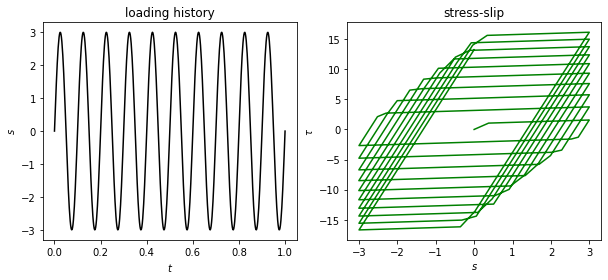

In [27]:
n_cycles, s_max, n_steps = 10, 3, 500 # load history parameters
_E_b, _K, _tau_Y = 10, 0.2, 1 # material parameters
s_pl_k, z_k = 0, 0 # initialization of trial states
tau_list = [] # list to record the stresses
t_arr = np.linspace(0,1,n_steps) # time range t in (0,1)
theta = np.sin(2*n_cycles * np.pi * t_arr) # load history with unloading
s_n1_arr = s_max * theta # load history
for s_n1 in s_n1_arr:
    tau_k = _E_b * (s_n1 - s_pl_k) # elastic trial step
    Z_k = _K * z_k # isotropic hardening
    f_k = np.abs( tau_k ) - Z_k - _tau_Y
    if f_k > 0: # inelastic step - return mapping
        delta_lambda_k = f_k / (_E_b + _K)
        s_pl_k += delta_lambda_k * np.sign(tau_k)
        z_k += delta_lambda_k # to save lines n=n+1 is shortend to k
        tau_k = _E_b * (s_n1 - s_pl_k)
    tau_list.append(tau_k) # record the calculated stress
_, (ax_t, ax_tau) = plt.subplots(1,2,figsize=(10,4))
ax_t.plot(t_arr, s_n1_arr,color='black'); ax_t.set_ylabel('$s$'), ax_t.set_xlabel('$t$')
ax_tau.plot(s_n1_arr, tau_list, color='green'); ax_tau.set_ylabel(r'$\tau$'), ax_tau.set_xlabel('$s$');
ax_t.set_title('loading history'); ax_tau.set_title('stress-slip'); 

### Tasks and questions
 1. Extend the model with kinematic hardening $X = \gamma \alpha$ following the lecture video V0403.
 2. Use the model extended model to find and extend answers to questions in exercise X0401.
 3. What behavior is obtained for one loading cycle with $K = 0.1, \gamma = -0.1$ and for $K = -0.1, \gamma = 0.1$ - for monotonic and for cyclic loading?
 4. Use the model to find an explanation why do the interchanged signs for kinematic and isotropic hardening lead to a completely different cyclic response.